<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%EB%A7%88%EB%A5%B4%EC%BD%94%ED%94%84%EC%B6%94%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터를 불러오자

^GSPC	S&P 500
^DJI	Dow Jones Industrial Average
^FTSE	FTSE 100
^N225	Nikkei 225
^HSI	HANG SENG INDEX


                  High         Low  ...      Volume   Adj Close
Date                                ...                        
2019-01-02  25824.4395  25055.2695  ...  1666316400  25130.3496
2019-01-03  25262.2109  24896.8691  ...  1481291700  25064.3594
2019-01-04  25626.0293  24924.7305  ...  1708572100  25626.0293
2019-01-07  26043.6406  25753.4609  ...  1447090300  25835.6992
2019-01-08  25960.8906  25688.5000  ...  1578205700  25875.4492
...                ...         ...  ...         ...         ...
2020-11-25  27040.4102  26591.3008  ...  2859974400  26669.7500
2020-11-26  26819.4492  26612.0000  ...  1977652900  26819.4492
2020-11-27  27009.1504  26704.5996  ...  2733597200  26894.6797
2020-11-30  26960.9297  26322.6797  ...  5742060100  26341.4902
2020-12-01  26662.1797  26375.2402  ...  3564238900  26567.6797

[473 rows x 6 columns]


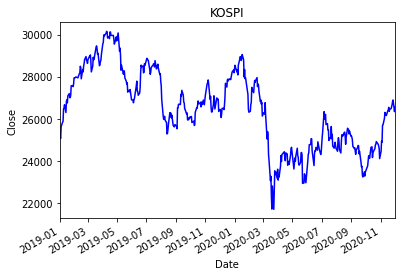

In [ ]:
import pandas_datareader as wb
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('precision', 4)
 
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 11, 30)
df_null = wb.DataReader('^HSI',"yahoo",start,end)
# ^GSPC
df = df_null.dropna()
 
kospi_chart = df.Close.plot(style='b')
kospi_chart.set_title('KOSPI')
kospi_chart.set_ylabel("Close")
kospi_chart.set_xlim(str(start), str(end))
 
print(df)
 
#print("Close Median", df['Close'].median())
#print(df['Close'].describe())
#print(df.corr())
 
plt.show()

# 성장율로 바꾸자 log[y(t)]-log[y(t-1)]

num of obs= 271


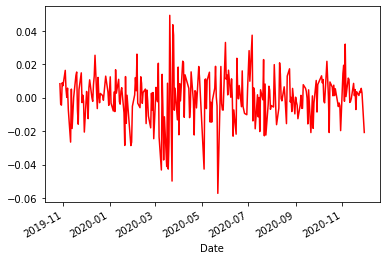

In [ ]:
import warnings
warnings.filterwarnings('ignore')

returns=df[200:472]
returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

data=returns.change
data.plot(style='r')

print("num of obs=",len(returns))

# 모듈을 불러오자

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8

import arviz as az
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns

     |████████████████████████████████| 1.4MB 6.3MB/s 
     |████████████████████████████████| 4.3MB 18.1MB/s 
     |████████████████████████████████| 296kB 33.8MB/s 
     |████████████████████████████████| 911kB 5.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


Probability of the initial state

# Log likelihood of the states

vector version

# 주요 컨트롤 변수

In [ ]:
n_states= 2
model=3
n_draw =2000
n_tune=500
n_chain=1

# 모델 설정

In [ ]:
import theano.tensor as tt
import theano.tensor.slinalg as sla  # theano-wrapped scipy linear algebra
import theano.tensor.nlinalg as nla  # theano-wrapped numpy linear algebra
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

class HMMStates(pm.Categorical):
    def __init__(self, p_transition, p_equilibrium, n_states, *args, **kwargs):
        """You can ignore this section for the time being."""
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.p_equilibrium = p_equilibrium
        # This is needed
        self.k = n_states
        # This is only needed because discrete distributions must define a mode.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        """Focus your attention here!"""
        p_eq = self.p_equilibrium
        # Broadcast out the transition probabilities,
        # so that we can broadcast the calculation
        # of log-likelihoods
        p_tr = self.p_transition[x[:-1]]

        # the logp of the initial state evaluated against the equilibrium probabilities
        initial_state_logp = pm.Categorical.dist(p_eq).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

def solve_equilibrium(n_states, p_transition):
    A = tt.dmatrix('A')
    A = tt.eye(n_states) - p_transition + tt.ones(shape=(n_states, n_states))
    p_equilibrium = pm.Deterministic("p_equilibrium", sla.solve(A.T, tt.ones(shape=(n_states))))
    return p_equilibrium

class HMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.mu = mu
        self.sigma = sigma

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        mu = self.mu[states]
        sigma = self.sigma[states]
        return tt.sum(pm.Normal.dist(mu=mu, sigma=sigma).logp(x))

class ARHMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, k, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma  # variance
        self.k = k  # autoregressive coefficient.

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        sigma = self.sigma[states]
        k = self.k

        ar_mean = k * x[:-1]
        ar_like = tt.sum(pm.Normal.dist(mu=ar_mean, sigma=sigma[1:]).logp(x[1:]))

        boundary_like = pm.Normal.dist(mu=0, sigma=sigma[0]).logp(x[0])
        return ar_like + boundary_like

with pm.Model() as model1:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=p_transition,
        p_equilibrium=p_equilibrium,
        n_states=n_states,
        shape=(len(data),)
    )

    # Prior for mu and sigma
    mu = pm.Normal("mu", mu=0, sigma=1, shape=(n_states,))
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))

    # Observed emission likelihood
    obs = HMMGaussianEmissions(
        "emission",
        states=hmm_states,
        mu=mu,
        sigma=sigma,
        observed=data
    )


with pm.Model() as model2:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=p_transition,
        p_equilibrium=p_equilibrium,
        n_states=n_states,
        shape=(len(data),)
    )

    # Prior for sigma and k
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))
    k = pm.Beta("k", alpha=2, beta=2) # a not-so-weak prior for k
#    k = pm.Normal("k", mu=0.5, sigma=2, shape=(n_states,))

    # Observed emission likelihood
    obs = ARHMMGaussianEmissions(
        "emission",
        states=hmm_states,
        sigma=sigma,
        k=k,
        observed=data
    )


# 상태별 k 계수 작업 중

In [ ]:
class ARHM(pm.Continuous):
    def __init__(self, states, k,sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma  # variance
        self.k = k  # autoregressive coefficient.
      
    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        sigma = self.sigma[states]
        k = self.k[states]
        ar_mean = k[1:]*x[:-1]    # 각 time에서의 ar 평균
        ar_like = tt.sum(pm.Normal.dist(mu=ar_mean, sigma=sigma[1:]).logp(x[1:]))
        boundary_like = pm.Normal.dist(mu=0, sigma=sigma[0]).logp(x[0])
        return ar_like + boundary_like

with pm.Model() as model3:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=p_transition,
        p_equilibrium=p_equilibrium,
        n_states=n_states,
        shape=(len(data),)
    )

    # Prior for sigma and k
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))
#    k = pm.Beta("k", alpha=2, beta=2) # a not-so-weak prior for k
    k = pm.Normal("k", mu=0.5, sigma=2, shape=(n_states,))

    # Observed emission likelihood
    obs = ARHM(
        "emission",
        states=hmm_states,
        sigma=sigma,
        k=k,observed=data
    )


In [ ]:
pm.summary(trace, var_names=["sigma", "k", "p_equilibrium"])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.011,0.001,0.010,0.013,0.000,0.000,70.0,70.0,71.0,119.0,NaN
sigma[1],0.032,0.007,0.021,0.045,0.001,0.000,98.0,98.0,81.0,164.0,NaN
k[0],-0.030,0.070,-0.167,0.095,0.003,0.002,548.0,548.0,566.0,957.0,NaN
k[1],-0.123,0.239,-0.566,0.350,0.008,0.008,848.0,492.0,878.0,516.0,NaN
p_equilibrium[0],0.873,0.071,0.753,0.981,0.007,0.005,90.0,90.0,96.0,336.0,NaN
p_equilibrium[1],0.127,0.071,0.019,0.247,0.007,0.005,90.0,90.0,96.0,336.0,NaN


# 포스테리어 샘플링

In [ ]:
if model==1:
    with model1:
      trace = pm.sample(draws=n_draw, tune=n_tune, chains=n_chain)
elif model==2: 
    with model2:
       trace = pm.sample(draws=n_draw, tune=n_tune, chains=n_chain)
elif model==3: 
    with model3:
      trace = pm.sample(draws=n_draw, tune=n_tune, chains=n_chain)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [k, sigma, p_transition]
>BinaryGibbsMetropolis: [hmm_states]
Sampling chain 0, 1 divergences: 100%|██████████| 2500/2500 [02:50<00:00, 14.65it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


# 결과요약

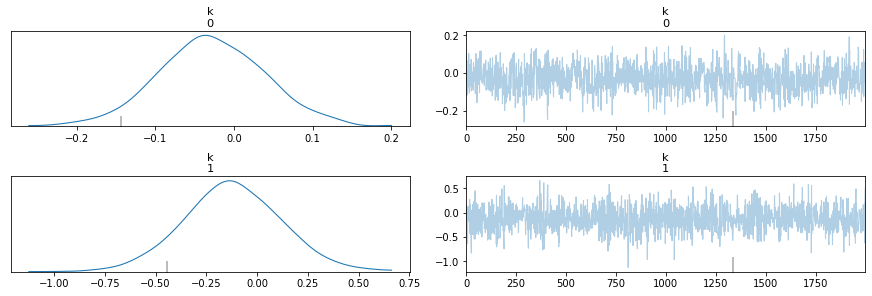

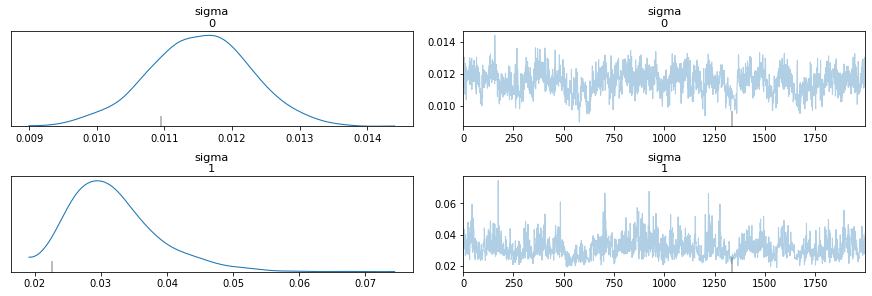

In [ ]:
if model==1:
  az.plot_trace(trace, var_names=["mu"]);
  az.plot_trace(trace, var_names=["sigma"]);
  
elif model>=2:
# az.plot_forest(trace, var_names=["k"]);
  az.plot_trace(trace, var_names=["k"]);
  az.plot_trace(trace, var_names=["sigma"]);

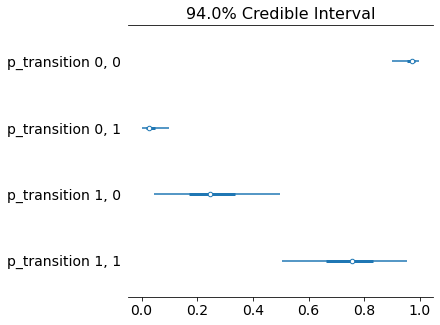

In [ ]:
az.plot_forest(trace, var_names=["p_transition"]);


# 각 시점에서 상태 1의 사후분포 확률 (de-coding)

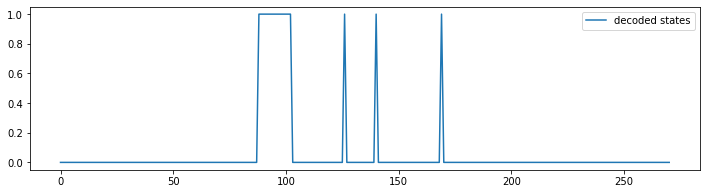

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(np.round(trace.hmm_states.mean(axis=0)), label="decoded states")
plt.legend();

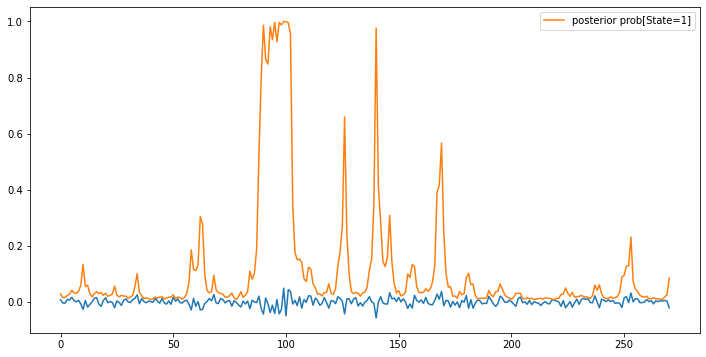

In [ ]:
yy=data.to_numpy()
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(yy)
plt.plot((trace.hmm_states.mean(axis=0)), label="posterior prob[State=1]")
plt.legend();